<h1>The relationship of translation invariance to the weights of the convolutional neural net.</h1>


In this document I attempt to relate the functional property of translation invariance, where a unit has the same pattern of responses to a set of shapes at one position as another, to the parameters of a convolutional neural net. 

<h3>Analysis</h3>
Previously we have found that even though the architecture of convolution and max-pooling is meant to produce translation invariance, unless the network is trained the network does not have translation invariance. Clearly then our property depends on the weights of the network, my goal is to understand the form of this dependency. I hope that the form of this dependency can be simple, that by using summary statistics in patterns of the weights we can make predictions on the degree of TI in a given unit.

<h3>Synthesis</h3>
I can then generate network parameters which depend on these summary statistics I claim produce translation invariance. I would hypothesise that even random weights as long they depend on these summary statistics will have good TI.

<h3>Image statistics</h3>
All weights are the result of a weighted sum of the inputs at each stage. For example in the first stage all filters are simply a weighted linear sum of image patches. So once we understand the form of this dependency it will then be a goal to understand what properties over sums of natural images, and their transformations by previous layers of the network induce these properties.

<h3>Analysis</h3>
Lets begin by loading the weights of the network then create a dataframe of a couple different summary statistics on those weights.

In [147]:
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline  
top_dir = os.getcwd().split('ipython_nb')[0]
sys.path.append(top_dir + 'xarray')
top_dir = top_dir+ 'v4cnn/'
sys.path.append(top_dir)
sys.path.append(top_dir + 'common')
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import d_img_process as di
import d_misc as dm


import itertools
flatten_iter = itertools.chain.from_iterable
def factors(n):
    return set(flatten_iter((i, n//i) 
                for i in range(1, int(n**0.5)+1) if n % i == 0))
goforit=True       
if 'a' not in locals() or goforit:
    with open(top_dir + 'nets/netwts.p', 'rb') as f:    
        try:
            netwts = pickle.load(f, encoding='latin1')
        except:
            netwts = pickle.load(f)

In [148]:
print([wts[1].shape for wts in netwts])
netwts[5][1] = netwts[5][1].reshape((4096, 256, 6, 6)) 

[(96, 3, 11, 11), (256, 48, 5, 5), (384, 256, 3, 3), (384, 192, 3, 3), (256, 192, 3, 3), (4096, 9216), (4096, 4096), (1000, 4096)]


In [149]:
da = xr.open_dataset(top_dir + '/data/responses/bvlc_reference_caffenet_APC362_pix_width[32.0]_x_(74.0, 154.0, 21)_y_(74.0, 154.0, 21)_amp_None.nc')['resp']
da = da.squeeze()
da = da.transpose('unit','shapes', 'x', 'y')
da = da.load()
subsamp = 1
da = da[::subsamp, ...] #subsample
da = da.load()
da = da - da[:, 0, 0, 0] #subtract off baseline
da = da[:, 1:, ...] #get rid of baseline shape

(96, 3, 11, 11)
96
(256, 48, 5, 5)
256
(384, 256, 3, 3)
384
(384, 192, 3, 3)
384
(256, 192, 3, 3)
256
(4096, 256, 6, 6)
4096


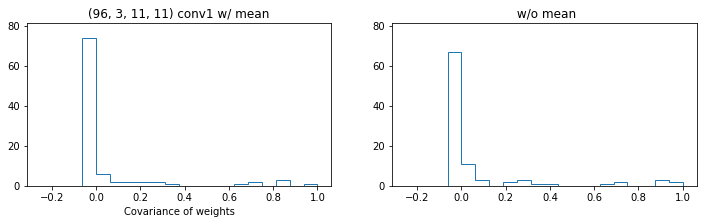

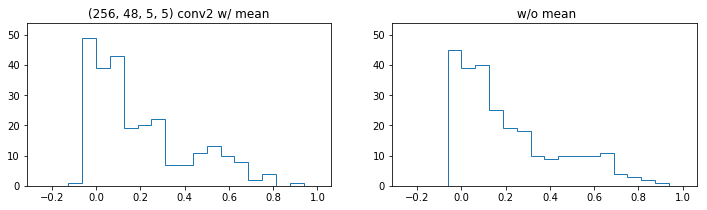

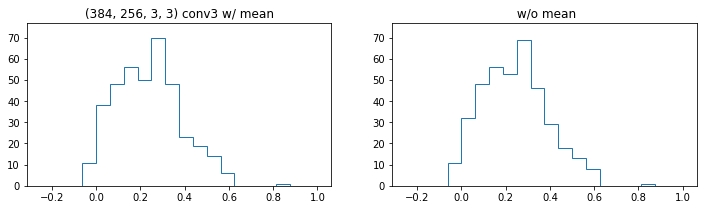

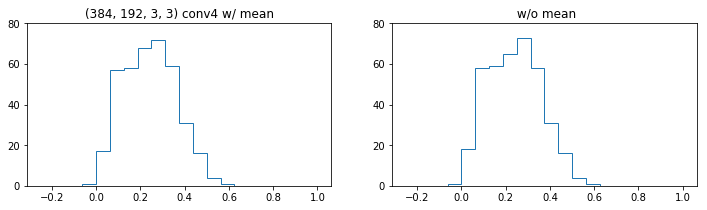

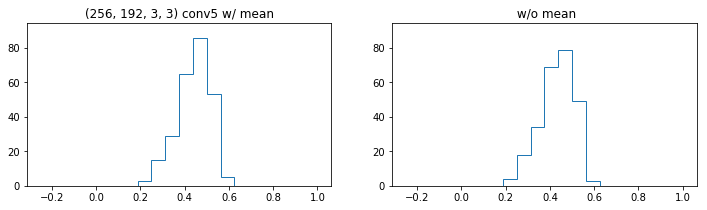

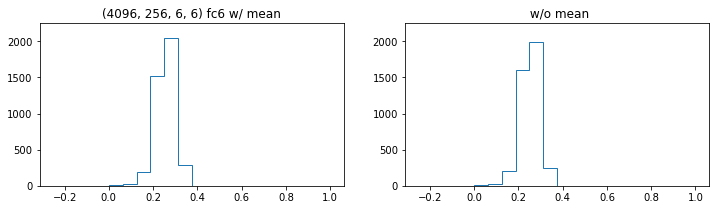

In [150]:
#lets calculate the spatial covariance of these kernels.
def ti_av_cov(da, inclmean=True, rtrn_space=False):
    dims = da.coords.dims
    #get the da in the right shape
    if ('x' in dims) and ('y' in dims):
        da = da.transpose('unit','shapes', 'x', 'y')
        ti_spc = np.zeros((np.shape(da)[0], np.shape(da)[2], np.shape(da)[3]))
    elif ('x' in dims):
        da = da.transpose('unit', 'shapes', 'x')
        ti_spc = np.zeros((np.shape(da)[0], np.shape(da)[2]))
    elif ('y' in dims):
        da = da.transpose('unit', 'shapes', 'y')
        ti_spc = np.zeros((np.shape(da)[0], np.shape(da)[2]))
        
    #some data to store
    ti = np.zeros(np.shape(da)[0])
    
    
    dens = np.zeros(np.shape(da)[0])
    nums = np.zeros(np.shape(da)[0])
    tot_vars = np.zeros(np.shape(da)[0])
    kurt_shapes = np.zeros(np.shape(da)[0])
    kurt_x =  np.zeros(np.shape(da)[0])

    for i, unit_resp in enumerate(da):
        if len(unit_resp.shape)>2:
            #unwrap spatial
            unit_resp = unit_resp.values.reshape(unit_resp.shape[0], unit_resp.shape[1]*unit_resp.shape[2])   
        else:
            unit_resp = unit_resp.values
        unit_resp = unit_resp.astype(np.float64)
        if not inclmean:
            unit_resp = unit_resp - np.mean(unit_resp, 0, keepdims=True, dtype=np.float64)
 

        cov = np.dot(unit_resp.T, unit_resp)
        cov[np.diag_indices_from(cov)] = 0
        cov_spc = cov.sum(0)
        numerator = np.sum(np.triu(cov))

        vlength = np.linalg.norm(unit_resp, axis=0, keepdims=True)
        max_cov = np.outer(vlength.T, vlength)
        max_cov[np.diag_indices_from(max_cov)] = 0
        max_cov_spc = max_cov.sum(0)
        denominator= np.sum(np.triu(max_cov))
        
        
        #trying to output correctly the shape of normalized covariance in a map.
        
        den = np.sum(max_cov)
        num = np.sum(cov)
        dens[i] = den
        nums[i] = num
        tot_vars[i] = np.sum(unit_resp**2)
        if den!=0 and num!=0:
            ti[i] = num/den
            ti_spc[i] = np.reshape(cov_spc / max_cov_spc, np.shape(da)[2:])
        
        
    if rtrn_space:
        return ti_spc
    else:
        return ti

ti_by_layer = []
layer_labels = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6']
for layer, layer_name in zip(netwts, layer_labels):
    print(layer[1].shape)
    if len(layer[1].shape)>2:
        _ = xr.DataArray(layer[1], dims=['unit', 'shapes', 'x', 'y'])
        ti = ti_av_cov(_)
        print(len(ti))
        ti_by_layer.append(ti)
        plt.figure(figsize=(12,3))
        ax1 = plt.subplot(121)
        n1 = plt.hist(ti, range=[-.25,1], bins=20, histtype='step')[0]
        plt.title(str(layer[1].shape) + ' ' + layer_name + ' w/ mean') 
        if layer_name is 'conv1':
            plt.xlabel('Covariance of weights')
        ax2 = plt.subplot(122)
        ti = ti_av_cov(_, inclmean=False)
        n2 = plt.hist(ti, range=[-.25,1], bins=20, histtype='step')[0]
        plt.title(' w/o mean')
        ax1.set_ylim([0,max([np.max(n1), np.max(n2)])*1.1])
        ax2.set_ylim([0,max([np.max(n1), np.max(n2)])*1.1])
        

Conv1: There is a clear peak at 0, this is most likely because conv1 tends to be opponent i.e. most weights fall on a line that is balanced across the origin.
Conv2: There is still a peak at 0 so it is still largely opponent but the peak isn't as strong, there is starting to be alot more covariance, i.e. everything is starting to be on one side of the origin... our control subtracting out the mean shows that this isn't just the result of a high mean.
Conv3: Now the peak goes away from 0, there is not as much opponency, but also the range has compressed as there is not as much range, this would imply more filters are starting to spatially decorrelate.
Conv4: The range stays about the same though maybe contracts a little.
Conv5: The range shifts upwards and contracts, spatial correlation increases.
fc 6 : I was lazy and have not done it yet it will require figuring out how the weights map onto the 6x6 map after conv5. Presumably I could also trace  back from fc7 to fc6 etc.

Now we ask what is the structure of this covariance.

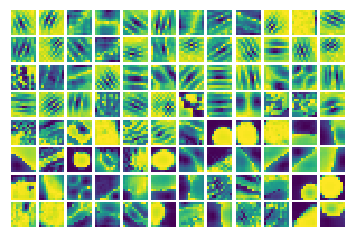

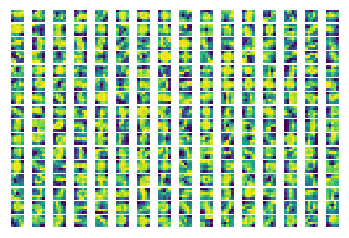

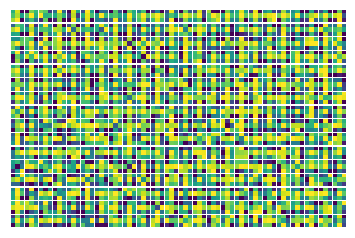

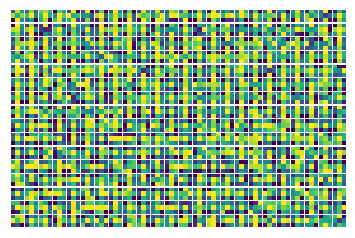

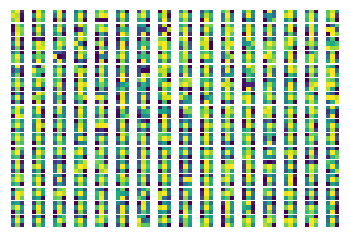

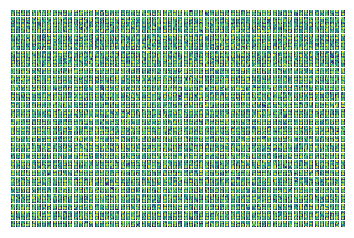

In [152]:
import matplotlib.gridspec as gridspec

make_plots = True
ti_maps = []
for layer, layer_name in zip(netwts, layer_labels):
    if len(layer[1].shape)>2:
        _ = xr.DataArray(layer[1], dims=['unit', 'shapes', 'x', 'y'])
        ti_map = ti_av_cov(_, rtrn_space=True)
        ti_maps.append(ti)
        if make_plots:
            m, n = close_factors(layer[1].shape[0])
            plt.figure(figsize=(6,4),)
            plot_id = np.arange(0, m*n).reshape(m, n)
            gs = gridspec.GridSpec(m,n)
            gs.update(wspace=.1, hspace=.1)   
            p_num = -1
            for unit in ti_map:
                p_num += 1
                ax = plt.subplot(gs[p_num])
                unit_sc = unit/unit.sum()
                ax.imshow(unit.T, interpolation = 'nearest')        
                ax.set_xticks([]);ax.set_yticks([]);
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["bottom"].set_visible(False)
                ax.spines["left"].set_visible(False)

In [153]:
#now lets get the receptive fiel
def close_factors(n):
    factor_list = []
    for n_in in range(1,n):
        if (n%n_in) == 0:
            factor_list.append(n_in)
    factor_array = np.array(factor_list)
    paired_factors = np.array([factor_array, n/factor_array])
    paired_factors.shape
    best_ind = np.argmin(abs(paired_factors[1]-paired_factors[0]))
    closest_factors = paired_factors[:,best_ind]
    return closest_factors[0], closest_factors[1]

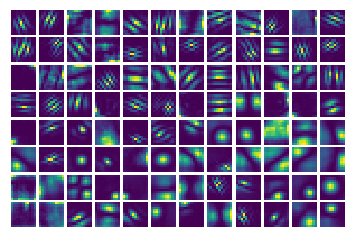

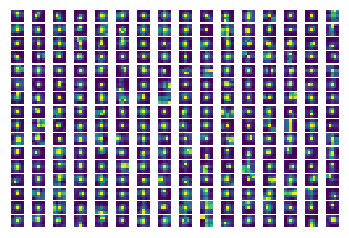

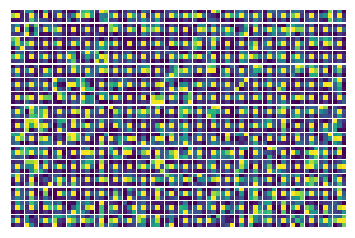

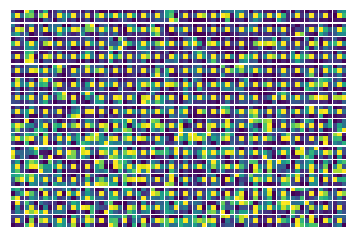

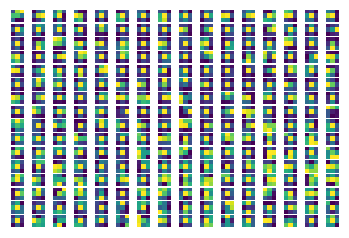

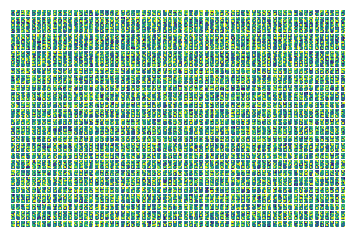

In [154]:
import matplotlib.gridspec as gridspec

make_plots = True
rfs = []
for layer, layer_name in zip(netwts, layer_labels):
    if len(layer[1].shape)>2:
        rf = np.sum(layer[1]**2, 1)
        rfs.append(rf)
        if make_plots:
            m, n = close_factors(layer[1].shape[0])
            plt.figure(figsize=(6,4),)
            plot_id = np.arange(0, m*n).reshape(m, n)
            gs = gridspec.GridSpec(m,n)
            gs.update(wspace=.1, hspace=.1)   
            p_num = -1
            for unit in rf:
                p_num += 1
                ax = plt.subplot(gs[p_num])
                unit_sc = unit/unit.sum()
                ax.imshow(unit.T, interpolation = 'nearest')        
                ax.set_xticks([]);ax.set_yticks([]);
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["bottom"].set_visible(False)
                ax.spines["left"].set_visible(False)


Here I plot the power of the weights at each spatial position of all conv1-5 layers. It is clear that most tend to have centered receptive fields, where inputs have the greatest effect on computation when they are closer to the center of the kernel. Though of course there is some variance.  I will describe this feature of a centered receptive field (because I think it might have something to do with TI and definitely to do with image statistics) as the positivity of a linear fit of the the distance of a weight from center, and its power.


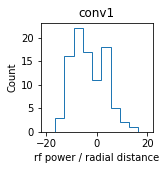

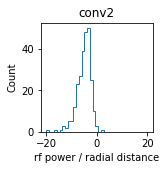

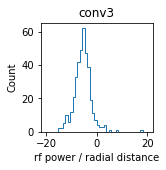

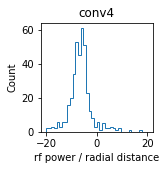

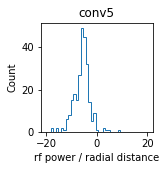

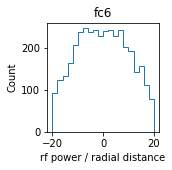

In [155]:
from scipy.stats import linregress
slopes_l = []
for rf, label in zip(rfs, layer_labels):
    width = rf[0].shape[1]
    width_steps = np.arange(rf[0].shape[1])
    x, y = np.meshgrid(width_steps, width_steps) - np.floor(width/2.)
    d = np.sqrt(x**2 + y**2)
    d = d/d.max()
    
    slopes = [linregress((unit/unit.sum()).ravel(), d.ravel())[0]
              for unit in rf]
    slopes_l.append(slopes)
    plt.figure(figsize=(2,2))
    plt.hist(slopes, range=[-20,20], bins='auto', histtype='step')
    plt.xlabel('rf power / radial distance')
    plt.ylabel('Count')
    plt.title(label)
    

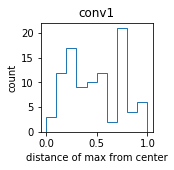

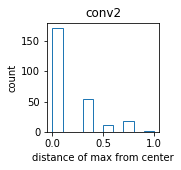

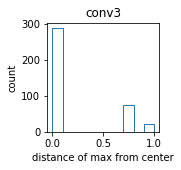

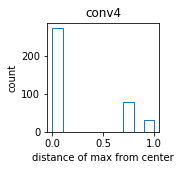

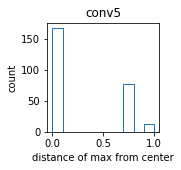

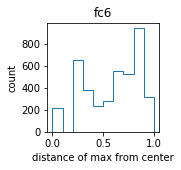

In [156]:
max_rad_dist_l = []
for rf, label in zip(rfs, layer_labels):
    width = rf[0].shape[1]
    width_steps = np.arange(width)
    x, y = np.meshgrid(width_steps, width_steps) - np.floor(width/2.)
    d = np.sqrt(x**2 + y**2)
    d = d/d.max()
    
    max_rad_dist = [d.ravel()[unit.ravel().argmax()]
              for unit in rf]
    max_rad_dist_l.append(max_rad_dist)
    plt.figure(figsize=(2,2))
    plt.hist(max_rad_dist, range=[0,1], bins=10, histtype='step')
    plt.xlabel('distance of max from center')
    plt.ylabel('count')
    plt.title(label)
#plt.legend(layer_labels)


maybe make something for measuring bandwidth as defined by the slope of power as a function of distance from max.

In [157]:
max_rad_dist = np.concatenate(max_rad_dist_l)
wt_cov = np.concatenate(ti_by_layer)
rf_cntr_out_slp = np.concatenate(slopes_l)

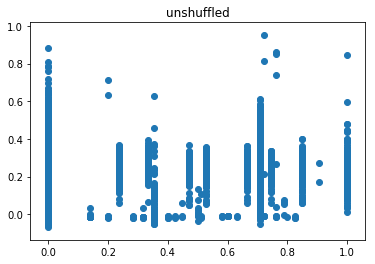

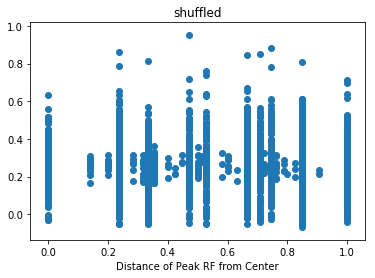

In [158]:
plt.figure()
plt.scatter(max_rad_dist, wt_cov)
plt.title('unshuffled')
plt.figure()
plt.scatter(max_rad_dist, wt_cov[::-1])
plt.title('shuffled')
plt.xlabel('Distance of Peak RF from Center')

Now lets measure the TI we measured on the network, to see if it relates to any of our measurements on the weights.

In [159]:
da = xr.open_dataset(top_dir + '/data/responses/bvlc_reference_caffenet_APC362_pix_width[32.0]_x_(74.0, 154.0, 21)_y_(74.0, 154.0, 21)_amp_None.nc')['resp']
da = da[:,0,:,:,:]
da.dims


('shapes', 'x', 'y', 'unit')

In [160]:
#da = da.squeeze()
da = da.transpose('unit','shapes', 'x', 'y')
da = da[::subsamp, ...] #subsample
da = da.load()
da = da - da[:, 0, 0, 0] #subtract off baseline
da = da[:, 1:, ...] #get rid of baseline shape

In [161]:
da.dims

('unit', 'shapes', 'x', 'y')

In [162]:
from scipy.stats import kurtosis

def ti_av_cov(da):
    dims = da.coords.dims
    #get the da in the right shape
    if ('x' in dims) and ('y' in dims):
        da = da.transpose('unit','shapes', 'x', 'y')
    elif ('x' in dims):
        da = da.transpose('unit', 'shapes', 'x')
    elif ('y' in dims):
        da = da.transpose('unit', 'shapes', 'y')
        
    #some data to store
    ti = np.zeros(np.shape(da)[0])
    dens = np.zeros(np.shape(da)[0])
    nums = np.zeros(np.shape(da)[0])
    tot_vars = np.zeros(np.shape(da)[0])
    kurt_shapes = np.zeros(np.shape(da)[0])
    kurt_x =  np.zeros(np.shape(da)[0])

    for i, unit_resp in enumerate(da):
        if len(unit_resp.shape)>2:
            #unwrap spatial
            unit_resp = unit_resp.values.reshape(unit_resp.shape[0], unit_resp.shape[1]*unit_resp.shape[2])   
        else:
            unit_resp = unit_resp.values
        unit_resp = unit_resp.astype(np.float64)
        unit_resp = unit_resp - np.mean(unit_resp, 0, keepdims=True, dtype=np.float64)
 

        cov = np.dot(unit_resp.T, unit_resp)
        cov[np.diag_indices_from(cov)] = 0
        numerator = np.sum(np.triu(cov))

        vlength = np.linalg.norm(unit_resp, axis=0, keepdims=True)
        max_cov = np.outer(vlength.T, vlength)
        max_cov[np.diag_indices_from(max_cov)] = 0
        denominator= np.sum(np.triu(max_cov))

        kurt_shapes[i] = kurtosis(np.sum(unit_resp**2, 1))
        kurt_x[i] = kurtosis(np.sum(unit_resp**2, 0))
        den = np.sum(max_cov)
        num = np.sum(cov)
        dens[i] = den
        nums[i] = num
        tot_vars[i] = np.sum(unit_resp**2)
        if den!=0 and num!=0:
            ti[i] = num/den 
    return ti, kurt_shapes, kurt_x, dens, nums, tot_vars

In [163]:
da.shape

(22096, 370, 21, 21)

In [164]:
#ti_x, kurt_shapes_x, kurt_x, dens, nums, tot_vars_x = ti_av_cov(da[:,:,:, 5])

#ti_x, kurt_shapes_x, kurt_x, dens, nums, tot_vars_x = ti_av_cov(da[:,:,:, 0])
#ti_y, kurt_shapes_y, kurt_y, dens, nums, tot_vars_y = ti_av_cov(da[:,:, 5, :])
ti_yx, kurt_shapes_yx, kurt_yx, dens, nums, tot_vars_yx = ti_av_cov(da[:, :, :, :])

In [165]:
da.shape

(22096, 370, 21, 21)

In [166]:
non_k_var = (kurt_shapes_yx<42) * (kurt_shapes_yx>2) * (tot_vars_yx>0) 

In [183]:
import pandas as pd
keys = ['layer_label', 'unit']
coord = [da.coords[key].values for key in keys]
index = pd.MultiIndex.from_arrays(coord, names=keys)
resp = pd.DataFrame(np.hstack([ti_yx,]), index=index, columns=['ti',])

In [186]:
layersbyunit = [[name,]*layer_wts[1].shape[0] for name, layer_wts in zip(layer_labels, netwts)]

In [187]:
keys = ['layer_label',]
index = pd.MultiIndex.from_arrays([np.concatenate(layersbyunit),], names=keys)
wts = pd.DataFrame(np.vstack([wt_cov, max_rad_dist, rf_cntr_out_slp]).T, index=index, columns=['wts_cov','mxrfdst', 'rf_slp'])

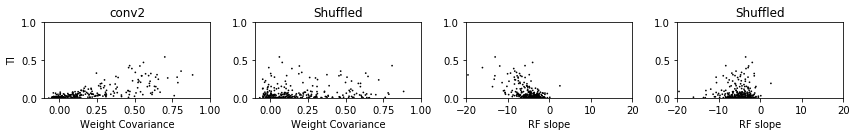

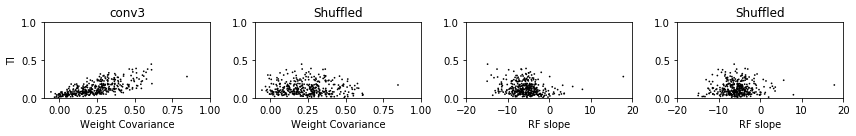

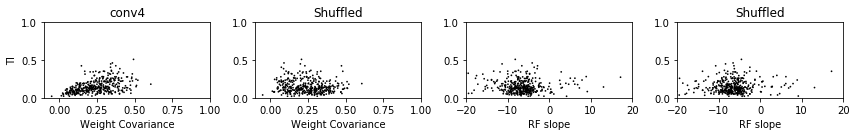

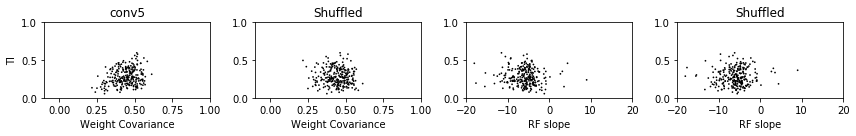

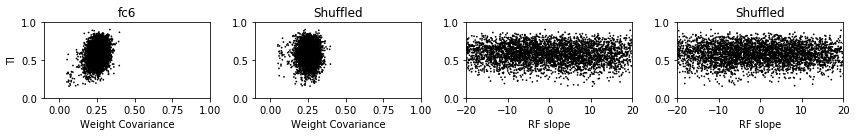

In [190]:
for layer in layer_labels[1:]:
    plt.figure(figsize=(12,2))
    plt.subplot(141)
    plt.scatter(wts.loc[layer]['wts_cov'].values, resp.loc[layer].values,s=3, color='k', edgecolors='none')
    #plt.semilogx()
    plt.xlim(-0.1,1);plt.ylim(0,1);plt.xlabel('Weight Covariance'); plt.ylabel('TI')
    plt.title(layer)
    
    plt.subplot(143)
    plt.scatter(wts.loc[layer]['rf_slp'].values, resp.loc[layer].values,s=3, color='k', edgecolors='none')
    plt.xlim(-20,20);plt.ylim(0,1);plt.xlabel('RF slope'); 
    plt.tight_layout()
    
    plt.subplot(142)
    plt.scatter(wts.loc[layer]['wts_cov'].values, resp.loc[layer].values[::-1],s=3, color='k', edgecolors='none')
    plt.xlim(-0.1,1);plt.ylim(0,1);plt.xlabel('Weight Covariance'); 
    plt.title('Shuffled')
    
    plt.subplot(144)
    plt.scatter(wts.loc[layer]['rf_slp'].values, resp.loc[layer].values[::-1],s=3, color='k', edgecolors='none')
    plt.xlim(-20,20);plt.ylim(0,1);plt.xlabel('RF slope'); 
    plt.title('Shuffled')

    plt.tight_layout()
    

There is a clear relationship between the TI and the covariance in the weights. This intuitively makes sense because the channels at each position are looking for the same pattern of inputs.
Originally when we made this measurement for a smaller spatial range the relationship was not as strong. Similarly when 